In [66]:
from pathlib import Path
import pandas as pd
import os, pdb
import numpy as np
import matplotlib.pyplot as plt

In [79]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#output file path
DATA_PATH = Path('/content/drive/MyDrive/vcf/LAMMPS/Ta_3.304_300K_100000t0s/')
#input file path
DATA_PATH_in = Path('/content/drive/MyDrive/vcf/LAMMPS/Ta_3.304_300K_100000t0s/input')

Mounted at /content/drive


In [80]:
files = os.listdir(DATA_PATH_in)

In [82]:
#creating .csv files and save in output directory
def save_dataframe(files):
  for f in files:
    print(f"Working with file {f}")
    with open(DATA_PATH_in / f) as _f:
      lines = _f.readlines()[8:]
    for i, line in enumerate(lines):
      line = [x.replace("\n", "") for x in line.split(" ")]
      if i == 0:
        df = pd.DataFrame(columns=line[2:])
      else:
        df.loc[i-1] = line
    _f = f+".csv"
    df.to_csv(DATA_PATH / "output" / _f, index=False)

In [83]:
save_dataframe(files)

Working with file dump.Ta_3.304_300K.12200
Working with file dump.Ta_3.304_300K.13200
Working with file dump.Ta_3.304_300K.12500
Working with file dump.Ta_3.304_300K.12600
Working with file dump.Ta_3.304_300K.13000
Working with file dump.Ta_3.304_300K.13100
Working with file dump.Ta_3.304_300K.12000
Working with file dump.Ta_3.304_300K.12400
Working with file dump.Ta_3.304_300K.12700
Working with file dump.Ta_3.304_300K.12300


KeyboardInterrupt: ignored

In [76]:
#Defining VACF function
def get_v_cf(f1, f2):
  f1 = pd.read_csv(DATA_PATH / "output" / f1)
  f2 = pd.read_csv(DATA_PATH / "output" / f2)

  v_numerator = ( f1.vx * f2.vx ) + ( f1.vy * f2.vy ) + ( f1.vz * f2.vz )
  v_denomenator = ( f1.vx * f1.vx ) + ( f1.vy * f1.vy ) + ( f1.vz * f1.vz )
  v_cf = np.sum(v_numerator)/np.sum(v_denomenator)

  return v_cf

In [77]:
#calculating VACF
v_cf = []
#time steps and dt
for i in range(0, 1000, 10):
  fname = f"dump.Ta_3.304_300K.{i}.csv"
  if i == 0:
    f_old = fname
    f_new = fname
    _v_cf = get_v_cf(f_old, f_new)
    v_cf.append(_v_cf)
  else:
    f_new = fname
    _v_cf = get_v_cf(f_old, f_new)
    v_cf.append(_v_cf)
    f_old = f_new

FileNotFoundError: ignored

In [45]:
v_cf

[1.0,
 0.7918493631420235,
 0.3829268664340061,
 0.4699451557243741,
 0.4659540616220805,
 0.6496215663148719,
 0.6913002038107553,
 0.5797476909575583,
 0.6773576138937834,
 0.6436787464839707,
 0.6190761125629367,
 0.6642641020950445,
 0.5463473971954356,
 0.5361432699496081,
 0.5887824712954621,
 0.6014920106532493,
 0.6438076421890973,
 0.6276318194461377,
 0.6916260249575565,
 0.626793201240167,
 0.5583002823453819,
 0.4928032688566108,
 0.49137356101658697,
 0.6220568516582451,
 0.7191718088738069,
 0.7006532827992962,
 0.5432119055560987,
 0.4137823148249868,
 0.5720813233392873,
 0.5854346124838867,
 0.6690690787243115,
 0.6227288475752535,
 0.5544351061233339,
 0.5746009387182534,
 0.641153601108532,
 0.6405215787943978,
 0.5947189313726555,
 0.4152377721520492,
 0.4712402866130361,
 0.6482044770325194,
 0.6803214256276472,
 0.6487727389824699,
 0.5197104090170309,
 0.458903838495691,
 0.5321870477971763,
 0.5446794226610493,
 0.6406732006598118,
 0.6600237874719764,
 0.550746

Text(0, 0.5, 'VACF')

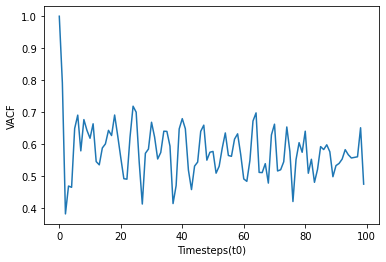

In [39]:
#VACF Plot
plt.plot(v_cf)
plt.xlabel('Timesteps(t0)')
plt.ylabel('VACF')


In [47]:
#fourier transform of VACF for DOS
def autocorr(X):
    """ the convolution is actually being done here
    meaning from -inf to inf so we only want half the
    array"""

    result = np.correlate(X, X, mode='full')
    return result[result.size/2:]

    
def fft_autocorr(AutoCorr,dt):
    """FFT of autocorrelation function"""
    #fft_arry = fftpack.dct(AutoCorr)*dt
    fft_arry = np.fft.rfft(AutoCorr)*dt
    return fft_arry


Text(0, 0.5, 'DOS')

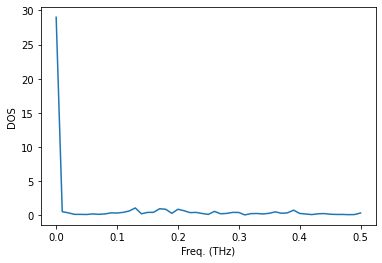

In [58]:
#Plot Discrete FT of VACF
#runtime total
dt = 0.005E-12*100
#size of frames
vsize=100
fft_v = fft_autocorr(v_cf,dt) * 1.0E12 #THz^-1     
freq = np.fft.rfftfreq(vsize, d=dt) /(2* 1.0E12) #THz
plt.plot(freq,np.abs(fft_v))
plt.xlabel('Freq. (THz)')
plt.ylabel('DOS')